In [1]:
%%javascript
if (IPython.notebook.kernel) {
    IPython.notebook.kernel.execute('book_name = "' + IPython.notebook.notebook_name+'"')
}

<IPython.core.display.Javascript object>

In [2]:
from __future__ import print_function

import sys
sys.path.append('..')

In [3]:
import os, numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from typing import Type, Any, Callable, Union, List, Optional
from torch import Tensor
from collections import OrderedDict

import time
from tqdm import tqdm
import random
import ipyparams
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from itertools import product
from scripts.utilities.data_calculator import get_mean_st
from scripts.customized_net.models import BasicBlock, WideResNet, ResNet
from scripts.customized_net.nervous_system import brain
from scripts.utilities.train_val import train

<IPython.core.display.Javascript object>

In [4]:
print(book_name)

experiment_id = int(book_name[book_name.rfind('seed')+4:len(book_name)-6:1]) # Experiment 1 - ResNet replicate
print("Experiment:",experiment_id)

cifar10_deep_resnet_ziyuan-seed1.ipynb
Experiment: 1


In [5]:
# np seed max 2**32 - 1
# https://numpy.org/doc/stable/reference/random/legacy.html
seed_factor = ((2**32 - 1)/60)

def set_seeds(seed, experiment_id=None):
    if not seed:
        seed = 10
        
    seed = int(seed * experiment_id)

    print("[ Using Seed : ", seed, " ]")

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [6]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [7]:
num_workers = 0
valid_size = 0.1
batch_size = 128

train_transform = transforms.Compose([transforms.ToTensor(),])
valid_transform = transforms.Compose([transforms.ToTensor(),])
test_transform = transforms.Compose([transforms.ToTensor(),])

train_data = datasets.CIFAR10('data', train=True, download=True, transform=train_transform)
valid_data = datasets.CIFAR10('data', train=True, download=True, transform=valid_transform)
test_data = datasets.CIFAR10('data', train=False, download=True, transform=test_transform)

set_seeds(seed_factor, experiment_id)
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler,
                          num_workers=num_workers, worker_init_fn=seed_worker)
valid_loader = DataLoader(valid_data, batch_size=batch_size, sampler=valid_sampler,
                          num_workers=num_workers, worker_init_fn=seed_worker)
test_loader  = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, 
                          worker_init_fn=seed_worker, shuffle=True)

train_mean, train_std = get_mean_st(train_loader)
valid_mean, valid_std = get_mean_st(valid_loader)
test_mean, test_std = get_mean_st(test_loader)
print(train_mean, train_std)
print(valid_mean, valid_std)
print(test_mean, test_std)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
[ Using Seed :  71582788  ]


100%|██████████| 79/79 [00:00<00:00, 83.55it/s]

tensor([0.4914, 0.4822, 0.4465]) tensor([0.2471, 0.2435, 0.2616])
tensor([0.4915, 0.4821, 0.4471]) tensor([0.2470, 0.2433, 0.2619])
tensor([0.4945, 0.4854, 0.4508]) tensor([0.2466, 0.2430, 0.2617])


In [8]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((32, 32)), # 32x32
    transforms.RandomCrop((32, 32), padding = 4), # 36x36 -> 32x32
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std),
])

valid_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(valid_mean, valid_std),
])

test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomCrop((32, 32), padding = 4),
    #transforms.RandomRotation(10),
    #transforms.ColorJitter(),
    #transforms.RandomAffine(10),
    transforms.ToTensor(),
    transforms.Normalize(test_mean, test_std),
])

In [9]:
num_workers = 0
valid_size = 0.1
batch_size = 128

train_data = datasets.CIFAR10('data', train=True, download=True, transform=train_transform)
valid_data = datasets.CIFAR10('data', train=True, download=True, transform=valid_transform)
test_data = datasets.CIFAR10('data', train=False, download=True, transform=test_transform)

##################
#### set seed ####
##################
set_seeds(seed_factor, experiment_id)
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, 
                               num_workers=num_workers, worker_init_fn=seed_worker)
valid_loader = DataLoader(valid_data, batch_size=batch_size, sampler=valid_sampler, 
                               num_workers=num_workers, worker_init_fn=seed_worker)

test_loader  = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, worker_init_fn=seed_worker, shuffle=True)
classes = test_loader.dataset.classes
classes

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
[ Using Seed :  71582788  ]


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

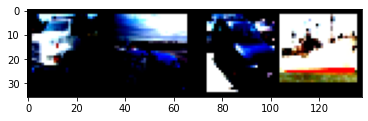

In [10]:
def imshow(img):
    img = np.clip(img, 0, 1)
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()

##################
#### set seed ####
##################
#set_seeds(seed_factor, experiment_id)
image_iter = iter(train_loader)
images, _ = image_iter.next()
imshow(torchvision.utils.make_grid(images[:4]))

In [ ]:
#set_seeds(seed_factor, experiment_id)
# image_iter = iter(valid_loader)
# images, _ = image_iter.next()
# imshow(torchvision.utils.make_grid(images[:4]))

- 258458

In [11]:
##################
#### set seed ####
##################
set_seeds(seed_factor, experiment_id)
deep_net = ResNet(BasicBlock, [3, 3, 3]) # ResNet34().to(device) n = {3, 5, 7, 9}
num_ftrs = deep_net.fc.in_features
deep_net.fc = nn.Linear(num_ftrs, 10)
deep_net_total_params = sum(p.numel() for p in deep_net.parameters())
print("DeepNet parameters:",deep_net_total_params)

[ Using Seed :  71582788  ]
DeepNet parameters: 272474


In [12]:
deep_net

ResNet(
  (stemblock): Sequential(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), str

from pprint import pprint
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(wide_net.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")
pprint(conv_layers)

outputs = []
names = []
image = torch.randn(2, 16, 32, 32)
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

n = 0
for name, param in wide_net.named_parameters():
    if "conv" in name or "fc.w" in name or "fc1." in name:
        n+=1
        print(f"Layer {n}:",name, param.data.shape)

n = 0
for name, param in wide_net.named_parameters():
    if "conv" in name or "fc.w" in name or "fc1." in name:
        n+=1
        print(f"Layer {n}:",name, param.data.shape)

wide_net

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(wide_net)

In [13]:
device_ids = [d for d in range(torch.cuda.device_count())]

device = f'cuda:{device_ids[0]}'

deep_net = deep_net.to(device)

if device == 'cuda:0':
    deep_net = nn.DataParallel(deep_net, device_ids)

device, device_ids

('cuda:0', [0, 1, 2, 3])

In [14]:
lr = 1e-1
momentum = 0.9
weight_decay = 5e-4 # 1e-4 # 5e-4

criterion = nn.CrossEntropyLoss()

##################
#### set seed ####
##################
#set_seeds(seed_factor, experiment_id)
deep_optimizer = optim.SGD(deep_net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay) # 1e-4
deep_scheduler = optim.lr_scheduler.CosineAnnealingLR(deep_optimizer, T_max=200, eta_min=0, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-01.


In [15]:
def net_name(model):
    if isinstance(model, nn.DataParallel):
        model_name = model.module.__class__.__name__
    else:
        model_name = model.__class__.__name__
    return model_name

In [16]:
nb_name = book_name
nb_name = os.path.splitext(nb_name.replace(" ","").replace("-","_").replace("%20","").lower())[0]
weights_path = 'pretrained/'+nb_name
deep_net_weights = weights_path+"_"+net_name(deep_net)+'.pt'
weights_path, deep_net_weights

('pretrained/cifar10_deep_resnet_ziyuan_seed1',
 'pretrained/cifar10_deep_resnet_ziyuan_seed1_ResNet.pt')

In [17]:
if os.path.exists(Path(weights_path).parent) == False:
    os.makedirs(Path(weights_path).parent)
else:
    print(Path(weights_path).parent, "exists")

load_model = ''
if load_model == "deep":
    checkpoint = torch.load(deep_net_weights)
    deep_net.load_state_dict(checkpoint['net'])
    start_epoch = checkpoint['epoch']
elif load_model == "wide":
    checkpoint = torch.load(wide_net_weights)
    deep_net.load_state_dict(checkpoint['net'])
    start_epoch = checkpoint['epoch']
else:
    start_epoch = 0
print('start_epoch: %s' % start_epoch)

pretrained exists
start_epoch: 0


In [18]:
net_name(deep_net)

'ResNet'

In [ ]:
# %psource train

In [ ]:
print("Started training on Experiment:", experiment_id)
start_time = time.time()
start_epoch = 0
epochs = 200

exchange = 10 # network exchange threshold

aggregated_epoch = 0

for epoch in range(start_epoch, epochs):
    
    if epoch == 0: set_seeds(seed_factor, experiment_id)

    aggregated_epoch+=1
    print("\nAggregated Epoch:", aggregated_epoch)
    model_state = train(epoch,deep_net,deep_net_weights,train_loader,valid_loader,deep_optimizer,criterion,deep_scheduler,device)

elapsed = (time.time() - start_time)/60
model_name = f"Wide ResNet20 Seed {experiment_id}"
print(f'Individual {model_name} Total Training Time: {elapsed:.2f} min')

- Epoch Valid Loss: 9.4052 | Best Global Accuracy 93.3000 | Best ResNet Accuracy 93.3000

In [ ]:
deep_net_weights_final = deep_net_weights.replace('.pt', '_final.pt')
print(deep_net_weights_final)

In [ ]:
torch.save(model_state, deep_net_weights_final)

In [19]:
print(deep_net_weights)
checkpoint = torch.load(deep_net_weights)
deep_net.load_state_dict(checkpoint['net'])
checkpoint.keys()

pretrained/cifar10_deep_resnet_ziyuan_seed1_ResNet.pt


dict_keys(['net', 'optimizer', 'epoch', 'output'])

In [20]:
print("Best check point happens at:", checkpoint['epoch'], "epoch")

Best check point happens at: 192 epoch


In [ ]:
# test_transform = transforms.Compose([
#     transforms.Resize((32, 32)),
#     #transforms.RandomHorizontalFlip(),
#     #transforms.RandomCrop((32, 32), padding = 4),
#     #transforms.RandomRotation(5),
#     #transforms.ColorJitter(),
#     #transforms.RandomAffine(5),
#     transforms.ToTensor(),
#     transforms.Normalize((0.4941, 0.4851, 0.4504), (0.2467, 0.2430, 0.2617)),
# ])
# 
# test_data = datasets.CIFAR10('data', train=False, download=True, transform=test_transform)
# 
# test_loader  = DataLoader(test_data,
#                           batch_size=batch_size, 
#                           num_workers=num_workers, 
#                           worker_init_fn=seed_worker,
#                           shuffle=True)

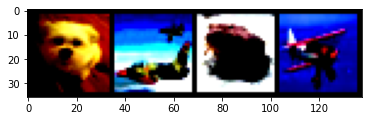

GroundTruth:    dog airplane  frog airplane
Predicted:    dog airplane  frog airplane
Accuracy of the network on the 10000 test images: 92.50%
Accuracy of airplane : 93.40%
Accuracy of automobile : 96.70%
Accuracy of  bird : 88.60%
Accuracy of   cat : 84.80%
Accuracy of  deer : 93.30%
Accuracy of   dog : 87.50%
Accuracy of  frog : 95.70%
Accuracy of horse : 94.00%
Accuracy of  ship : 96.20%
Accuracy of truck : 94.80%


In [21]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images[:4]
labels = labels[:4]
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

deep_net.eval()
with torch.no_grad():
    outputs = deep_net(images.to(device))
    _, predicted = torch.max(outputs.cpu(), 1)
    
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))
correct = 0
total = 0

deep_net.eval()
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = deep_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {total} test images: {100 * correct / total:.2f}%')

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

deep_net.eval()
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = deep_net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        if batch_size == c.shape[0]:
            for i in range(batch_size):
                class_correct[labels[i].item()] += c[i].item()
                class_total[labels[i].item()] += 1
        else:
            for i in range(c.shape[0]):
                class_correct[labels[i].item()] += c[i].item()
                class_total[labels[i].item()] += 1

each_class_list = []

for i in range(10):
    class_acc = 100 * class_correct[i] / class_total[i]
    each_class_list.append(class_acc)
    print('Accuracy of %5s : %.2f%%' % (
        classes[i], class_acc))

Files already downloaded and verified


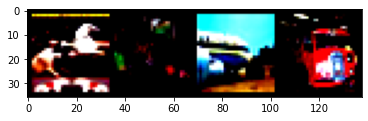

GroundTruth:  horse   cat airplane truck


In [96]:
test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomCrop((32, 32), padding = 4),
    #transforms.RandomRotation(5),
    #transforms.ColorJitter(),
    #transforms.RandomAffine(5),
    transforms.ToTensor(),
    transforms.Normalize((0.4941, 0.4851, 0.4504), (0.2467, 0.2430, 0.2617)),
])

test_data = datasets.CIFAR10('data', train=False, download=True, transform=test_transform)

test_loader  = DataLoader(test_data,
                          batch_size=batch_size, 
                          num_workers=num_workers, 
                          worker_init_fn=seed_worker,
                          shuffle=True)

dataiter = iter(test_loader)
images, labels = dataiter.next()

images = images[:4]
labels = labels[:4]
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

[ Using Seed :  71582788  ]
Files already downloaded and verified

Crop 1


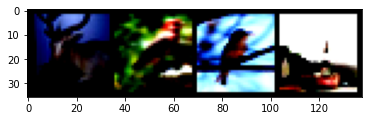

GroundTruth:   deer  bird  bird  ship

Crop 2


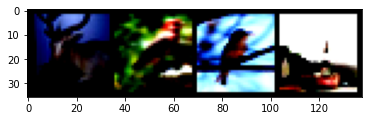

GroundTruth:   deer  bird  bird  ship

Crop 3


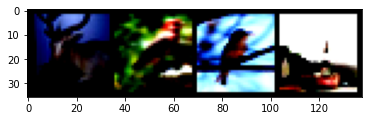

GroundTruth:   deer  bird  bird  ship

Crop 4


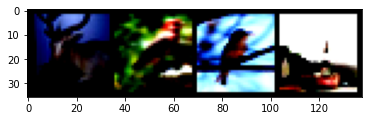

GroundTruth:   deer  bird  bird  ship

Crop 5


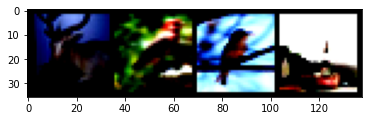

GroundTruth:   deer  bird  bird  ship

Crop 6


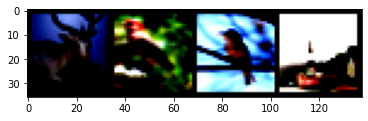

GroundTruth:   deer  bird  bird  ship

Crop 7


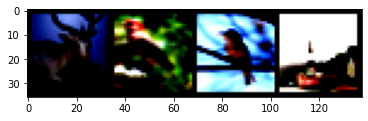

GroundTruth:   deer  bird  bird  ship

Crop 8


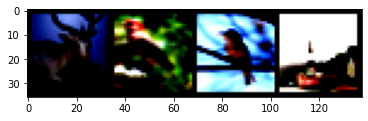

GroundTruth:   deer  bird  bird  ship

Crop 9


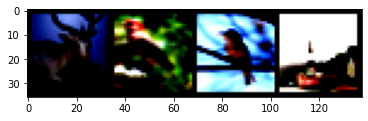

GroundTruth:   deer  bird  bird  ship

Crop 10


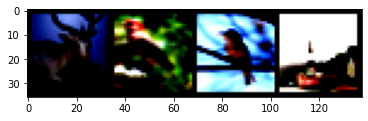

GroundTruth:   deer  bird  bird  ship


In [146]:
normalize = transforms.Normalize(mean=test_mean,std=test_std)

test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.TenCrop(32),
    lambda x: [normalize(transforms.functional.to_tensor(img)) for img in x]
])

set_seeds(seed_factor, experiment_id)

test_data = datasets.CIFAR10('data', train=False, download=True, transform=test_transform)

test_loader  = DataLoader(test_data,
                          batch_size=batch_size, 
                          num_workers=num_workers, 
                          worker_init_fn=seed_worker,
                          shuffle=True)

dataiter = iter(test_loader)
images_, labels = dataiter.next()
    
for i in range(10):
    print(f"\nCrop {i+1}")
    images = images_[i][:4]
    labels = labels[:4]
    # print images
    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

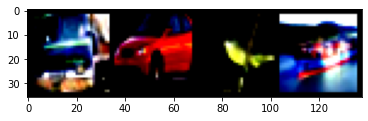

GroundTruth:  truck automobile  bird  ship
Predicted:  truck automobile  bird  ship


In [120]:
dataiter = iter(test_loader)
images_, labels = dataiter.next()

images = images_[7][:4]
labels = labels[:4]
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

deep_net.eval()
with torch.no_grad():
    outputs = deep_net(images.to(device))
    _, predicted = torch.max(outputs.cpu(), 1)
    
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [133]:
correct = 0
total = 0
corps = 10

deep_net.eval()
with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
        images_, labels = data, target
        for crop in range(corps):
            images = images_[crop]
            images, labels = images.to(device), labels.to(device)
            outputs = deep_net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {total} test images: {100 * correct / total:.2f}%')

Accuracy of the network on the 100000 test images: 92.43%


In [ ]:
print(np.sum(class_total), np.var(each_class_list), np.std(each_class_list), np.mean(each_class_list))

In [ ]:
def plot_confusion_matrix(conf_mat,
                          hide_spines=False,
                          hide_ticks=False,
                          figsize=None,
                          cmap=None,
                          colorbar=False,
                          show_absolute=True,
                          show_normed=False,
                          class_names=None):

    if not (show_absolute or show_normed):
        raise AssertionError('Both show_absolute and show_normed are False')
    if class_names is not None and len(class_names) != len(conf_mat):
        raise AssertionError('len(class_names) should be equal to number of'
                             'classes in the dataset')

    total_samples = conf_mat.sum(axis=1)[:, np.newaxis]
    normed_conf_mat = conf_mat.astype('float') / total_samples

    fig, ax = plt.subplots(figsize=figsize)
    ax.grid(False)
    if cmap is None:
        cmap = plt.cm.Blues

    if figsize is None:
        figsize = (len(conf_mat)*1.25, len(conf_mat)*1.25)

    if show_normed:
        matshow = ax.matshow(normed_conf_mat, cmap=cmap)
    else:
        matshow = ax.matshow(conf_mat, cmap=cmap)

    if colorbar:
        fig.colorbar(matshow)

    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            cell_text = ""
            if show_absolute:
                cell_text += format(conf_mat[i, j], 'd')
                if show_normed:
                    cell_text += "\n" + '('
                    cell_text += format(normed_conf_mat[i, j], '.2f') + ')'
            else:
                cell_text += format(normed_conf_mat[i, j], '.2f')
            ax.text(x=j,
                    y=i,
                    s=cell_text,
                    va='center',
                    ha='center',
                    color="white" if normed_conf_mat[i, j] > 0.5 else "black")
    
    if class_names is not None:
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=90)
        plt.yticks(tick_marks, class_names)
        
    if hide_spines:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    if hide_ticks:
        ax.axes.get_yaxis().set_ticks([])
        ax.axes.get_xaxis().set_ticks([])

    plt.xlabel('predicted label')
    plt.ylabel('true label')
    return fig, ax

def compute_confusion_matrix(model, data_loader, device):

    all_targets, all_predictions = [], []
    with torch.no_grad():

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets
            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)
            all_targets.extend(targets.to('cpu'))
            all_predictions.extend(predicted_labels.to('cpu'))

    all_predictions = all_predictions
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
        
    class_labels = np.unique(np.concatenate((all_targets, all_predictions)))
    if class_labels.shape[0] == 1:
        if class_labels[0] != 0:
            class_labels = np.array([0, class_labels[0]])
        else:
            class_labels = np.array([class_labels[0], 1])
    n_labels = class_labels.shape[0]
    lst = []
    z = list(zip(all_targets, all_predictions))
    for combi in product(class_labels, repeat=2):
        lst.append(z.count(combi))
    mat = np.asarray(lst)[:, None].reshape(n_labels, n_labels)
    return mat

In [ ]:
idx2class = {v: k for k, v in test_loader.dataset.class_to_idx.items()}
idx2class

In [ ]:
mat = compute_confusion_matrix(model=deep_net, data_loader=test_loader, device=device)
plot_confusion_matrix(mat, class_names=idx2class.values())
plt.show()
mat

In [ ]:
model_state["confusion_matrix"] = mat
torch.save(model_state, deep_net_weights_final)
print(deep_net_weights_final)
checkpoint = torch.load(deep_net_weights_final)
checkpoint.keys()
mat1 = checkpoint['confusion_matrix']
mat1

In [ ]:
seed_path = deep_net_weights_final.replace('seed1','seed2')
print(seed_path)
checkpoint = torch.load(seed_path)
print(checkpoint.keys())
confusion_matrix = checkpoint['confusion_matrix']
mat2 = confusion_matrix

seed_path = deep_net_weights_final.replace('seed1','seed3')
print(seed_path)
checkpoint = torch.load(seed_path)
print(checkpoint.keys())
confusion_matrix = checkpoint['confusion_matrix']
mat3 = confusion_matrix

seed_path = deep_net_weights_final.replace('seed1','seed4')
print(seed_path)
checkpoint = torch.load(seed_path)
print(checkpoint.keys())
confusion_matrix = checkpoint['confusion_matrix']
mat4 = confusion_matrix

seed_path = deep_net_weights_final.replace('seed1','seed5')
print(seed_path)
checkpoint = torch.load(seed_path)
print(checkpoint.keys())
confusion_matrix = checkpoint['confusion_matrix']
mat5 = confusion_matrix

mat_all = mat1+mat2+mat3+mat4+mat5

In [ ]:
plot_confusion_matrix(mat_all, class_names=idx2class.values())
plt.title('ResNet20 Confusion Matrix (5 Seeds)')
plt.show()

In [ ]:
# %psource train
# train_loss, train_acc, train_loss_list, val_loss, val_acc, valid_loss_list
print(deep_net_weights_final)
checkpoint = torch.load(deep_net_weights_final)
print(checkpoint.keys())
deep_output = checkpoint['output']

In [ ]:
train_loss, train_acc, train_loss_list, val_loss, val_acc, valid_loss_list = [], [], [], [], [], []
for idx, d in enumerate(deep_output):
    # train_loss, train_acc, train_loss_list, val_loss, val_acc, valid_loss_list
    train_loss.append(d[0])
    train_acc.append(d[1])
    train_loss_list.append(d[2])
    val_loss.append(d[3])
    val_acc.append(d[4])
    valid_loss_list.append(d[5])

In [ ]:
train_mini_loss_mean, val_mini_loss_mean = [], []
for d, i in enumerate(train_loss_list):
    #print("batch", d+1,":", np.mean(i))
    train_mini_loss_mean.append(np.mean(i))
    #print(np.mean(i))
for d, i in enumerate(valid_loss_list):
    #print("batch", d+1,":", np.mean(i))
    val_mini_loss_mean.append(np.mean(i))
    
train_epoch_acc = train_acc
valid_epoch_acc = val_acc

In [ ]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter( y=train_mini_loss_mean, name="Train Loss"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=val_mini_loss_mean, name="Validation Loss"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=train_epoch_acc, name="Train Accuracy"),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter( y=valid_epoch_acc, name="Validation Accuracy"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Loss/Accuracy of ResNet20 with CIFAR10"
)

# Set x-axis title
fig.update_xaxes(title_text="Epoch")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Train/Validation</b> Loss", secondary_y=False)
fig.update_yaxes(title_text="<b>Train/Validation</b> Accuracy", secondary_y=True)
fig.update_layout(yaxis_range=[-0.1,2.5])
fig.show()

In [ ]:
train_valid_output = train_mini_loss_mean, val_mini_loss_mean, train_epoch_acc, valid_epoch_acc

model_state["train_valid_output"] = train_valid_output
torch.save(model_state, deep_net_weights_final)
print(deep_net_weights_final)
checkpoint = torch.load(deep_net_weights_final)
print(checkpoint.keys())
train_valid_output = checkpoint['train_valid_output']
seed1_train_valid = train_valid_output
seed1_train_valid

In [ ]:
seed_path = deep_net_weights_final.replace('seed1','seed2')
print(seed_path)
checkpoint = torch.load(seed_path)
seed2_train_valid = train_valid_output
seed2_train_valid

In [ ]:
seed_path = deep_net_weights_final.replace('seed1','seed3')
print(seed_path)
checkpoint = torch.load(seed_path)
print(checkpoint.keys())
train_valid_output = checkpoint['train_valid_output']
seed3_train_valid = train_valid_output
seed3_train_valid

In [ ]:
seed_path = deep_net_weights_final.replace('seed1','seed4')
print(seed_path)
checkpoint = torch.load(seed_path)
seed4_train_valid = train_valid_output
seed4_train_valid

In [ ]:
seed_path = deep_net_weights_final.replace('seed1','seed5')
print(seed_path)
checkpoint = torch.load(seed_path)
seed5_train_valid = train_valid_output
seed5_train_valid

In [ ]:
train_mini_loss_mean1, val_mini_loss_mean1, train_epoch_acc1, valid_epoch_acc1 = seed1_train_valid
train_mini_loss_mean2, val_mini_loss_mean2, train_epoch_acc2, valid_epoch_acc2 = seed2_train_valid
train_mini_loss_mean3, val_mini_loss_mean3, train_epoch_acc3, valid_epoch_acc3 = seed3_train_valid
train_mini_loss_mean4, val_mini_loss_mean4, train_epoch_acc4, valid_epoch_acc4 = seed4_train_valid
train_mini_loss_mean5, val_mini_loss_mean5, train_epoch_acc5, valid_epoch_acc5 = seed5_train_valid

In [ ]:
train_mini_loss_mean_all = (np.array(train_mini_loss_mean1)+ 
                            np.array(train_mini_loss_mean2)+
                            np.array(train_mini_loss_mean3)+
                            np.array(train_mini_loss_mean4)+
                            np.array(train_mini_loss_mean5))/5
val_mini_loss_mean_all = (np.array(val_mini_loss_mean1)+ 
                          np.array(val_mini_loss_mean2)+
                          np.array(val_mini_loss_mean3)+
                          np.array(val_mini_loss_mean4)+
                          np.array(val_mini_loss_mean5))/5
train_epoch_acc_all = (np.array(train_epoch_acc1)+ 
                       np.array(train_epoch_acc2)+
                       np.array(train_epoch_acc3)+
                       np.array(train_epoch_acc4)+
                       np.array(train_epoch_acc5))/5
valid_epoch_acc_all = (np.array(valid_epoch_acc1)+ 
                       np.array(valid_epoch_acc2)+
                       np.array(valid_epoch_acc3)+
                       np.array(valid_epoch_acc4)+
                       np.array(valid_epoch_acc5))/5

In [ ]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter( y=train_mini_loss_mean_all, name="Train Loss"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=val_mini_loss_mean_all, name="Validation Loss"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=train_epoch_acc_all, name="Train Accuracy"),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter( y=valid_epoch_acc_all, name="Validation Accuracy"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Loss/Accuracy of ResNet20 with CIFAR10 (5 Seeds)"
)

# Set x-axis title
fig.update_xaxes(title_text="Epoch")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Train/Validation</b> Loss", secondary_y=False)
fig.update_yaxes(title_text="<b>Train/Validation</b> Accuracy", secondary_y=True)
fig.update_layout(yaxis_range=[-0.1,1.8])
fig.show()

In [ ]:
np.max(train_mini_loss_mean), np.min(train_mini_loss_mean)

In [ ]:
test_list = []

for i in range(0,200):
    correct = 0
    total = 0
    wide_net.eval()
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = wide_net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    print(f"Prediction {i+1} Acc: {acc}")
    test_list.append(acc)

def list_mean(lst):
    return sum(lst) / len(lst)

print("Prediction Average",round(list_mean(test_list),2))